In [105]:
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict

import pandas  as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from fourier_flows.SequentialFlows import RealNVP, FourierFlow

from utils.data import DimUniversalStandardScaler
from scipy.special import kl_div

In [52]:
dataset_path = Path("data/raiffeisen_transactions/")

mcc = pd.read_csv(dataset_path / "mcc2big.csv").drop_duplicates()
mcc.columns = ["mcc", "big"]
mcc2big = {}
for _, row in mcc.iterrows():
    mcc2big[row["mcc"]] = row["big"]
del mcc

train = pd.read_csv(dataset_path / "train_set.csv", usecols=["customer_id", "amount", "mcc", "transaction_date", "currency"], parse_dates=["transaction_date"])
train["big"] = train["mcc"].map(mcc2big.get)
train = train[train.currency == 643].drop(columns=["currency"])
train

,amount,customer_id,mcc,transaction_date,big
0,2.884034,0dc0137d280a2a82d2dc89282450ff1b,5261,2017-07-15,75.0
1,2.775633,0dc0137d280a2a82d2dc89282450ff1b,5261,2017-10-27,75.0
2,3.708368,0dc0137d280a2a82d2dc89282450ff1b,5992,2017-10-03,80.0
3,2.787498,0dc0137d280a2a82d2dc89282450ff1b,5261,2017-09-09,75.0
4,2.892510,0dc0137d280a2a82d2dc89282450ff1b,5261,2017-07-06,75.0
...,...,...,...,...,...
1224729,2.601024,381bcceaad6c0d72a795e2f09950b3af,6011,2017-03-06,78.0
1224730,2.717837,90ffc453a1c176755ef9225a77df81a1,6011,2017-03-18,78.0
1224731,2.859485,90ffc453a1c176755ef9225a77df81a1,6011,2017-02-26,78.0
1224732,3.715220,5b4e3e9f63d011a61a8d4fa065b6fa97,6011,2017-02-20,78.0


In [53]:
train.customer_id.unique().__len__()

10000

In [54]:
train.groupby("customer_id", as_index=False).agg(transactions=("amount", "count")).describe()

,transactions
count,10000.000000
mean,121.793500
std,113.817844
min,11.000000
25%,42.000000
50%,85.000000
75%,166.000000
max,1887.000000


In [63]:
# customer_id - big (group_id) - transcations_counts (number of transactions by customer in group)
groups = train.groupby(["customer_id", "big"], as_index=False).agg(transcations_counts=("amount", "count"))

428
step: 0 	/ 50 	-	loss: 58.726
step: 49 	/ 50 	|	loss: -180.884
Finished training!
step: 0 	/ 50 	-	loss: 97.959
step: 49 	/ 50 	|	loss: -76.026
Finished training!


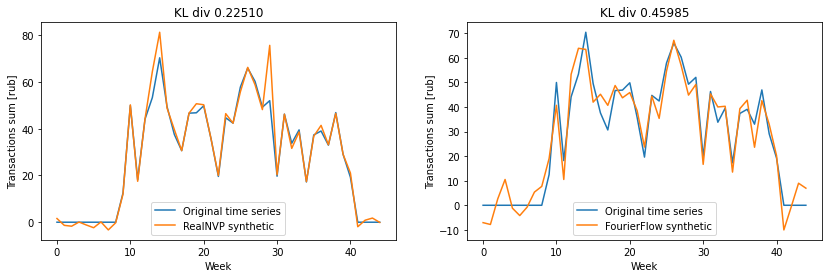

In [138]:
min_transactions = 400
min_week, max_week = train.transaction_date.dt.isocalendar().week.min(), train.transaction_date.dt.isocalendar().week.max()

for _, row in groups[groups.transcations_counts >= min_transactions].iterrows():
    # select data subset
    local = train[(train["customer_id"] == row["customer_id"]) & (train["big"] == row["big"])]
    # aggregate by weeks
    local = local.groupby(local.transaction_date.dt.isocalendar().week).agg(amount=("amount", "sum"))
    print(row["transcations_counts"])
    # fill missing weeks
    time_series = np.array([local.loc[i].amount if i in local.index else 0 for i in range(min_week, max_week + 1)])
    train_ts = time_series[:(len(time_series) // 4 * 4 + 1 if len(time_series) % 4 > 0 else len(time_series) - 3)]
    # scaling
    scaler = DimUniversalStandardScaler()
    train_ts = scaler.fit_transform(train_ts)
    
    # Fourier Flow
    torch.random.manual_seed(0)
    FF_model = FourierFlow(hidden=200, fft_size=len(train_ts), n_flows=10, normalize=False)

    FF_losses = FF_model.fit(train_ts.reshape(1, - 1), epochs=50, batch_size=128, 
                            learning_rate=1e-3, display_step=50)

    FF_synth_data = FF_model.sample(1)[0]

    del FF_model, FF_losses

    # RealNVP
    RealNVP_model = RealNVP(hidden=200, T=len(train_ts), n_flows=10, normalize=False)

    RealNVP_losses = RealNVP_model.fit(train_ts.reshape(1, - 1), epochs=50, batch_size=128, 
                            learning_rate=1e-3, display_step=50)

    RealNVP_synth_data = RealNVP_model.sample(1)[0]

    del RealNVP_model, RealNVP_losses

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    axs[0].plot(scaler.inverse_transform(train_ts))
    axs[0].plot(scaler.inverse_transform(RealNVP_synth_data))
    axs[0].legend(["Original time series", "RealNVP synthetic"])
    metric = np.mean([x for x in kl_div(
          scaler.inverse_transform(RealNVP_synth_data),scaler.inverse_transform(train_ts))
         if not np.isnan(x) and not np.isinf(x)])
    axs[0].set_title(f"KL div {metric:0.5f}")
    axs[1].plot(scaler.inverse_transform(train_ts))
    axs[1].plot(scaler.inverse_transform(FF_synth_data))
    axs[1].legend(["Original time series", "FourierFlow synthetic"])
    metric = np.mean([x for x in kl_div(
          scaler.inverse_transform(FF_synth_data),scaler.inverse_transform(train_ts))
         if not np.isnan(x) and not np.isinf(x)])
    axs[1].set_title(f"KL div {metric:0.5f}")
    for i in range(2):
     axs[i].set_xlabel("Week")
     axs[i].set_ylabel("Transactions sum [rub]")
    plt.show()

    break